In [ ]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


In [ ]:
!pip install --upgrade pip

import os
import yaml

with open("environment.yml") as file_handle:
    environment_data = yaml.safe_load(file_handle)

for dependency in environment_data["dependencies"]:
    if isinstance(dependency, dict):
      for lib in dependency['pip']:
        os.system(f"pip install {lib}")

In [ ]:
!pip install ray[tune]
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

In [4]:
!pip install torch==1.13.1

  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.


In [ ]:
# copy dataset from google drive to the actual machine
# !rm -rf /content/data/

import os 
DATA_FOLDER = '/content/data/shopee-product-matching/'
if not os.path.isdir(DATA_FOLDER):    
    !mkdir /content/data/
    !cp /content/drive/MyDrive/dl-project/shopee-product-matching.zip /content/data/shopee-product-matching.zip
    !unzip -q /content/data/shopee-product-matching.zip -d /content/data/shopee-product-matching

In [16]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import os

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from modules.datasets.TextSimpleLossShopeeDataset import TextSimpleLossShopeeDataset
from modules.distances.CosineDistance import CosineDistance
from modules.losses.SuperLoss import SuperLoss
from modules.models.BertWithCurricularFace import BertWithCurricularFace
from modules.models.BertWithArcFace import BertWithArcFace
from transformers import AutoTokenizer
import modules.utils.dataset_utils as dataset_utils
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import faiss

In [17]:
DATA_FOLDER = '/root/DL_Group_Project/dl-ecommerce-duplicates/shopee-product-matching/'

IS_TEST = False

df = dataset_utils.get_dataset(root=DATA_FOLDER, is_test=IS_TEST)
df = dataset_utils.add_target(df)
train = df.copy()
num_classes = train['label_group'].nunique()

train.shape

(34250, 6)

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
lbl_encoder = LabelEncoder()
train['label_code'] = lbl_encoder.fit_transform(train['label_group'])
num_classes = train['label_code'].nunique()

train_df, valid_df = train_test_split(train, test_size=0.2)

train_dataset = TextSimpleLossShopeeDataset(
    train_df['title'].values,
    train_df['label_code'].values)

valid_dataset = TextSimpleLossShopeeDataset(
    valid_df['title'].values,
    valid_df['label_code'].values)

num_classes

11014

In [19]:
class CFG:
    IMG_SZ = 256
    TRAIN_RATIO = 0.8
    EPOCHS = 10
    MARGIN = 0.5
    DISTANCE = CosineDistance()

In [20]:
from ray.air import session

def train_model(config, use_tune=True):

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    def collate_fn(batch):
        xs_1, ys = zip(*batch)

        xs_1 = tokenizer(list(xs_1), padding=True, truncation=True, return_tensors="pt")

        return xs_1, torch.stack(ys)
    
    # model = BertWithCurricularFace(n_classes=num_classes)
    model = BertWithCurricularFace(n_classes=num_classes, model_name = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1')
    # model = BertWithArcFace(num_classes=num_classes) 
    
    
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, _ = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config['factor'])
    
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           _, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        optimizer.load_state_dict(optimizer_state)
    # Datasets and data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
    )

    train_losses = []
    valid_losses = []
    ## Training loop: training + validation
    for epoch in range(CFG.EPOCHS):
        ## Training
        train_loss = 0.0
        epoch_steps = 0
        model.train()
        train_enumerator = enumerate(train_loader, 0)
        if not use_tune:
            train_enumerator = tqdm(train_enumerator)
        for i, data in train_enumerator:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1
            if i % 50 == 0:
                print("[%d, %5d / %d batches] loss: %.3f" % (epoch + 1, i + 1, len(train_loader),
                                                train_loss / epoch_steps))
        

        ## Validation
        val_loss = 0.0
        model.eval()
        valid_enumerator = enumerate(valid_loader, 0)
        if not use_tune:
            valid_enumerator = tqdm(valid_enumerator)
        for i, data in valid_enumerator:
            with torch.no_grad():
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, target)
                val_loss += loss.cpu().numpy()
        if use_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(
                val_loss=(val_loss / len(valid_loader)),
                train_loss=(train_loss / len(train_loader))
                )
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
    if not use_tune:
        return model, train_dataset, valid_dataset, train_losses, valid_losses

In [21]:
config = {
    "lr": tune.loguniform(1e-4, 1e-3),
    "batch_size": tune.choice([8]),
    "factor": tune.uniform(0.30,0.31),
}

In [22]:
def run_hyperparameter_search(num_samples, max_epochs, cpus_per_trial, gpus_per_trial):
    scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=max_epochs,
        grace_period=3,
        reduction_factor=3)
    reporter = CLIReporter(
        metric_columns=["train_loss", "val_loss", "training_iteration"]
        )
    result = tune.run(
        train_model,
        resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        # name="train_model_2023-04-23_16-29-56",
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="/root/ray_results",
        # resume="LOCAL+ERRORED",
        raise_on_failed_trial=False,)
    return result

In [ ]:
result = run_hyperparameter_search(num_samples=1, max_epochs=10, cpus_per_trial=4, gpus_per_trial=1)

In [24]:
# Keep it on google drive for the future 
# Takes a lot of memory
# !mkdir ./analysis/
# !mkdir ./analysis/cl-images/
# !cp -r /root/ray_results/train_model_2023-04-23_16-29-56 ./analysis/cl-images/

In [25]:
# best_trial = 'train_model_66040_00006'
# print(best_trial)
best_trial = result.get_best_trial("val_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final training loss: {}".format(best_trial.last_result["train_loss"]))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))

my_trials = [ trial for trial in list(result.trial_dataframes.keys()) if str(best_trial) in trial]
print(my_trials)
best_checkpoint = result.get_best_checkpoint(trial=my_trials[0], metric="val_loss", mode="min")
train_losses = result.trial_dataframes[my_trials[0]]["train_loss"].values
val_losses = result.trial_dataframes[my_trials[0]]["val_loss"].values
print(f"Train losses: {val_losses}")
print(f"Validation losses: {val_losses}")

Best trial config: {'lr': 0.00011063083244708989, 'batch_size': 8, 'factor': 0.3027242752349612}
Best trial final training loss: 9.06999914475601
Best trial final validation loss: 10.009407806841606
['/root/ray_results/train_model_2023-05-03_16-45-00/train_model_d8250_00000_0_batch_size=8,factor=0.3027,lr=0.0001_2023-05-03_16-45-00']
Train losses: [ 9.30542181  9.41428913  9.71032438  9.70016022  9.76425027  9.93652138
  9.89867394  9.92781541 10.03343802 10.00940781]
Validation losses: [ 9.30542181  9.41428913  9.71032438  9.70016022  9.76425027  9.93652138
  9.89867394  9.92781541 10.03343802 10.00940781]


In [26]:
val_losses.shape

(10,)

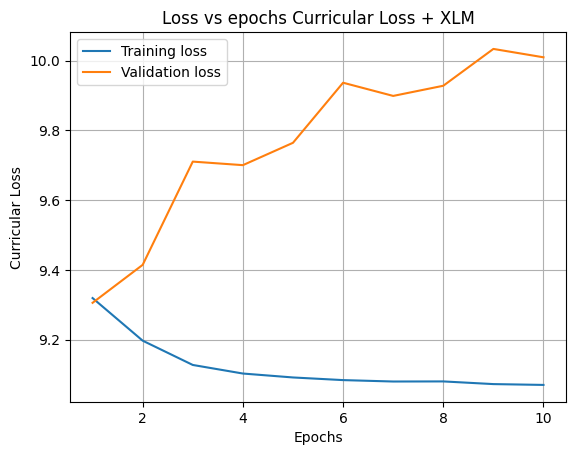

In [31]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, 11), train_losses, label='Training loss')
plt.plot(np.arange(1, 11), val_losses, label='Validation loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Curricular Loss')
plt.title('Loss vs epochs Curricular Loss + XLM')
plt.legend(loc='best')
plt.grid(True)

plt.savefig('text-curricular-loss-XLM-cosine-losses.png')

In [28]:
best_model = BertShopeeNet()
best_checkpoint_dir = best_checkpoint.to_directory(path="directory")
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
best_model.load_state_dict(model_state)
torch.save(best_model.state_dict(), f"./best_text_model_params_cosine_x1.pt")

NameError: name 'BertShopeeNet' is not defined

In [29]:
best_model.load_state_dict(torch.load("./best_text_model_params_cosine_x1.pt"))

NameError: name 'best_model' is not defined

In [26]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(DEVICE)

from modules.datasets.TextShopeeDataset import TextShopeeDataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 
def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs

text_dataset = TextShopeeDataset(train_df['title'].values)

text_loader = torch.utils.data.DataLoader(
    text_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=my_collate_fn,
)


text_embeddings = []
i = 0
best_model.eval()
with torch.no_grad():
    for data in tqdm(text_loader):
        i += 1
        data = data.to(DEVICE)
        embeddings = best_model(data)
        embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[1])
        embeddings = embeddings.detach().cpu().numpy()
        text_embeddings.extend(embeddings)

NameError: name 'best_model' is not defined

In [27]:
text_embeddings = np.stack(text_embeddings)
norms = np.linalg.norm(text_embeddings, axis=1)
text_embeddings = text_embeddings / norms[:, np.newaxis]
text_embeddings.shape

NameError: name 'text_embeddings' is not defined

In [ ]:
k = 100
res = faiss.StandardGpuResources()
index_img = faiss.IndexFlatIP(768)
# index_img = faiss.index_cpu_to_gpu(res, 0, index_img)
index_img.add(text_embeddings)
similarities_img, indexes_img = index_img.search(text_embeddings, k)

In [ ]:
def calc_f1_score(targets, results):
    intersect = len(np.intersect1d(targets, results))
    return 2 * intersect / (len(targets) + len(results))


def process_for_threshold(similarities, indexes, threshold):
    f1_score_accumulated = 0
    for i in range(len(text_embeddings)):
        cur_sims = similarities[i]
        cur_indexes = indexes[i]
        duplicate_indexes = cur_indexes[cur_sims >= threshold]
        results = train_df.iloc[duplicate_indexes]['posting_id'].values
        targets = train_df.iloc[i]['target']
        f1_score = calc_f1_score(targets, results)
        f1_score_accumulated += f1_score
    return f1_score_accumulated / len(text_embeddings)


thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores = []
for threshold in tqdm(thresholds):
    f1_avg = process_for_threshold(similarities_img, indexes_img, threshold)
    f1_avg_scores.append(f1_avg)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_avg_scores)

# Add labels and title
plt.xlabel('Threshold for cosine similarity')
plt.ylabel('Average F1-score')
plt.title('F1-score vs threshold for cosine text similarity')
plt.grid(True)

max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]

# Save the plot to a file
plt.savefig('bert-contrastive-loss-cosine-thresholds-all.png')

In [ ]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 